In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary
import numpy as np
import PIL

import torchvision
import torchvision.transforms
import random
import os.path as osp
import torch.nn.functional as F

from torch.utils.data.sampler import SubsetRandomSampler

from_numpy = torch.from_numpy

# **Data Normalization** 
Here we load the data and compute the average and std per channel

In [0]:
stats_transforms = torchvision.transforms.ToTensor()

stats_data = torchvision.datasets.ImageFolder(root='./trainset', 
                                               transform=stats_transforms)
len_data = len(stats_data)
stats_loader = torch.utils.data.DataLoader(stats_data, batch_size=1, 
                                           shuffle=False, num_workers=2)


In [0]:
images = []
for batch in stats_loader:
    x, y = batch
    images.append(x[0].numpy())
    
means = np.mean(np.asarray(images), axis=(0,2,3))
stds = np.std(np.asarray(images), axis=(0,2,3))
print(f'means : {means}')
print(f'stds : {stds}')

means : [0.48973456 0.45465884 0.4159725 ]
stds : [0.25206208 0.24510874 0.24726304]


In [0]:
## Load data and splits it between train and valid sets
SEED = 131214
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

data_size = (3,64,64)
batch_size = 64
classes_dict = {0:'Cat', 1:'Dog'}
distrib_means = (0.48973373, 0.45465815, 0.4159738)
distrib_stds = (0.25206217, 0.24510814, 0.24726307)
data_augmentation = True

# balanced training set as many cats than dogs
 
base_transforms = [torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(distrib_means, distrib_stds)]
 

if data_augmentation:
    r_choice = torchvision.transforms.RandomChoice
    compose = torchvision.transforms.Compose
    augmentations = [torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.RandomResizedCrop(64),
                    torchvision.transforms.RandomRotation(90),
                    torchvision.transforms.RandomVerticalFlip()]
    
    aug_transforms = compose(
    [torchvision.transforms.RandomApply([r_choice(augmentations +
                   [torchvision.transforms.RandomOrder(augmentations)])], 
                                        p=1)]
        + base_transforms)
else:
    aug_transforms = compose(base_compose)
    
base_transforms = compose(base_transforms)

# Creating data indices for training and validation splits:
indices = list(range(len_data))
id_split = int(0.9 * len_data)
np.random.shuffle(indices)
train_indices, valid_indices = indices[:id_split], indices[id_split:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)


train_data = torchvision.datasets.ImageFolder(root='./trainset', 
                                               transform=aug_transforms)

valid_data = torchvision.datasets.ImageFolder(root='./trainset', 
                                               transform=base_transforms)

train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=train_sampler, num_workers=2, 
        worker_init_fn = random.seed(SEED))

valid_loader = torch.utils.data.DataLoader(
        valid_data, batch_size=batch_size, sampler=valid_sampler, num_workers=2, 
        worker_init_fn = random.seed(SEED))

# **Here we visualize the data modifications**

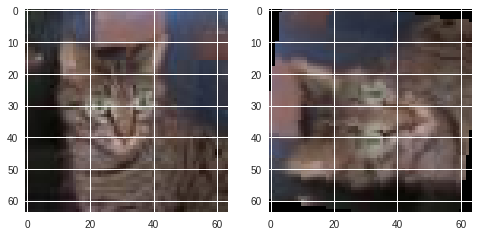

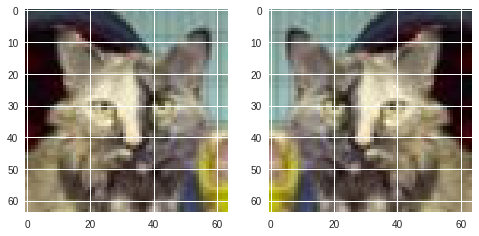

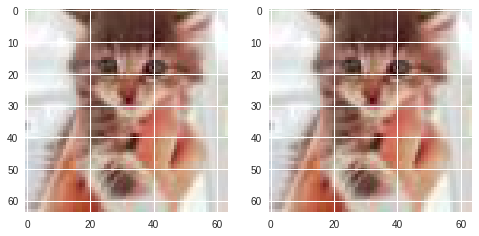

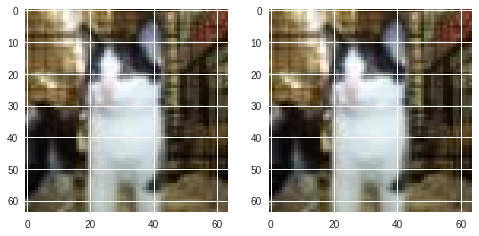

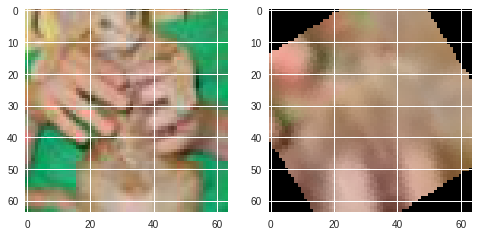

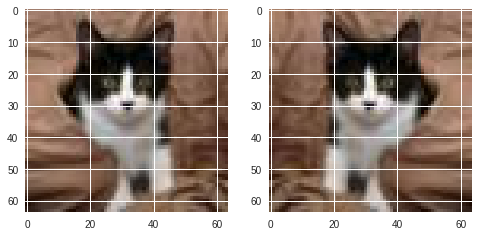

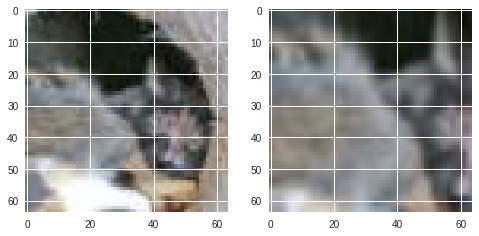

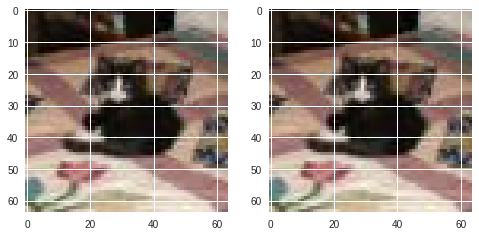

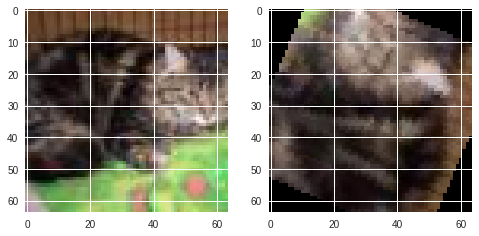

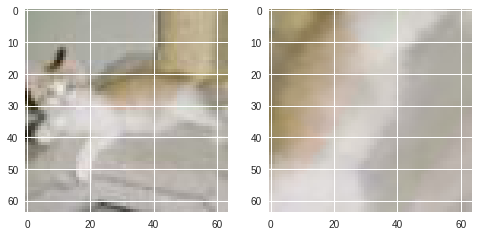

In [25]:
import matplotlib.pyplot as plt
distrib_stds = np.asarray(distrib_stds)
distrib_means = np.asarray(distrib_means)

aug_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, shuffle=False, num_workers=2, 
        worker_init_fn = random.seed(SEED))

vanilla_loader = torch.utils.data.DataLoader(
        valid_data, batch_size=batch_size, shuffle=False, num_workers=2, 
        worker_init_fn = random.seed(SEED))

def rescale_im(im):
    im = im.numpy()
    for ch in range(3):
        im[ch,:,:] = im[ch,:,:] * distrib_stds[ch] + distrib_means[ch]
    im = np.moveaxis(im,0,-1)
    return im

for batch_a, batch in zip(aug_loader, vanilla_loader):
    xa,y = batch_a
    x,y = batch
  
    for ima, im  in zip(xa[:10],x[:10]):
        ima = rescale_im(ima)
        im = rescale_im(im)
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(im)
        axarr[1].imshow(ima)
    break
    

# **Here we define the building blocks of our architecture**

In [0]:
#### Building blocks

class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x

## Resnet without batchNorm 
class ResidualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        # Conv Layer 1
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=stride, padding=1)
        
        # Conv Layer 2
        self.conv2 = nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=(3, 3), stride=1, padding=1)
    
        # Shortcut connection to downsample residual
        self.shortcut = nn.Sequential() ## equivalent to identity layer
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv2d(
                    in_channels=in_channels, out_channels=out_channels,
                    kernel_size=(1, 1), stride=stride)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out
      
    
class ResLinear(nn.Module):

    def __init__(self, in_features, out_features, activation=nn.ReLU()):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.activation = activation
        
        self.linear = nn.Linear(in_features, out_features)
        if in_features != out_features:
            self.project_linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        inner = self.activation(self.linear(x))
        if self.in_features != self.out_features:
            skip = self.project_linear(x)
        else:
            skip = x
        return inner + skip
    


# **The Models**

In [0]:
class CIFARResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Initial input conv
        self.conv1 = nn.Conv2d(
        in_channels=3, out_channels=64, kernel_size=(3, 3),
        stride=1, padding=1)
        
        # Create stages 1-4
        self.stage1 = self._create_stage(64, 64, stride=1)
        self.stage2 = self._create_stage(64, 128, stride=2)
        self.stage3 = self._create_stage(128, 256, stride=2)
        self.stage4 = self._create_stage(256, 512, stride=2)
        self.linear = nn.Linear(2048, num_classes)
        self.flatten = Flatten()
    
    # A stage is just two residual blocks for ResNet18
    def _create_stage(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = F.avg_pool2d(out, 4)
        out = self.flatten(out)
        out = self.linear(out)
        return out

In [49]:
# building model

model_type = 'ResNet'
cuda = torch.cuda.is_available()

if cuda:
    print('cuda is available')
else:
    print('cuda is not available')


if model_type == 'MLP':        
    model = nn.Sequential(
        ResLinear(784, 312),
        nn.ReLU(),
        ResLinear(312, 312),
        nn.ReLU(),
        ResLinear(312, 10)
    )
elif model_type == 'CNN':
    model = nn.Sequential(
        nn.Conv2d(3, 16, 5), #1 input channel, 16 output channel, 5x5 kernel
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 16, 5),
        nn.ReLU(),
        nn.MaxPool2d(2),
        Flatten(),
        ResLinear(2704, 100),
        nn.ReLU(),
        ResLinear(100, 10)
    )
elif model_type == 'ResNet':
    model = CIFARResNet18(num_classes=2)
    
if cuda:
    model = model.cuda()
    
summary(model,data_size)

cuda is available
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
            Conv2d-2           [-1, 64, 64, 64]          36,928
            Conv2d-3           [-1, 64, 64, 64]          36,928
     ResidualBlock-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,928
            Conv2d-6           [-1, 64, 64, 64]          36,928
     ResidualBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
            Conv2d-9          [-1, 128, 32, 32]         147,584
           Conv2d-10          [-1, 128, 32, 32]           8,320
    ResidualBlock-11          [-1, 128, 32, 32]               0
           Conv2d-12          [-1, 128, 32, 32]         147,584
           Conv2d-13          [-1, 128, 32, 32]         147,584
    ResidualBlock-14 

#**Optim parameters**

In [0]:
## Setting the optimizer
num_epochs = 200 # number of training epochs
lr0 = 0.1
#lr0 = 0.02
sched = 'on_plateau'
optimizer = optim.SGD(model.parameters(), lr=lr0)
if sched == 'on_plateau':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                               factor=0.5, patience=3, 
                                               mode='max')
else:
    lr_lambda = lambda epoch: 0.1**(epoch/float(num_epochs))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# **The Losses**

In [0]:
criterion = nn.CrossEntropyLoss() # to compute the loss
l2_coeff = 5e-4
## Defining the evaluation routines
def accuracy(proba, y):
    correct = torch.eq(proba.max(1)[1], y).sum().type(torch.FloatTensor)
    return correct / y.size(0)
  
def evaluate(dataset_loader, criterion):
    LOSSES = 0
    COUNTER = 0
    for batch in dataset_loader:
        optimizer.zero_grad()

        x, y = batch
        if model_type == 'MLP':
            x = x.view(-1,784)
            y = y.view(-1)
        elif model_type == 'CNN':
            x = x.view(-1,*data_size)
            y = y.view(-1)
            
        if cuda:
            x = x.cuda()
            y = y.cuda()
            
        loss = criterion(model(x), y)
        n = y.size(0)
        LOSSES += loss.sum().data.cpu().numpy() * n
        COUNTER += n
    
    return LOSSES / float(COUNTER)

def L2_loss(coeff):
    l = Variable(torch.FloatTensor(1), requires_grad=True).cuda()
    for w in model.named_parameters():
        if 'weight' in w[0]:
            l = l + 0.5*torch.pow(w[1], 2).sum()
    return l*coeff

# **The Training routine**

In [0]:
store_every = 1000
## Defines the train function
def train_model():
    root_path = f'./'
    LOSSES = 0
    COUNTER = 0
    ITERATIONS = 0
    learning_curve_nll_train = list()
    learning_curve_nll_valid = list()
    learning_curve_acc_train = list()
    learning_curve_acc_valid = list()
    best_acc = -np.inf
    for e in range(num_epochs):
        print(f'============= EPOCH {e} ========================')
        if not sched=='on_plateau':
            scheduler.step()
        for batch in train_loader:
            optimizer.zero_grad()

            x, y = batch
            if model_type == 'MLP':
                x = x.view(-1,784)
                y = y.view(-1)
            elif model_type == 'CNN':
                x = x.view(-1,*data_size)
                y = y.view(-1)
            if cuda:
                x = x.cuda()
                y = y.cuda()
           
            loss = criterion(model(x), y)
            if l2_coeff is not None:
                loss = loss + L2_loss(l2_coeff)
            loss.backward()
            optimizer.step()
            
            n = y.size(0)
            LOSSES += loss.sum().data.cpu().numpy() * n
            COUNTER += n
            ITERATIONS += 1
            if ITERATIONS%(store_every/5) == 0:
                avg_loss = LOSSES / float(COUNTER)
                LOSSES = 0
                COUNTER = 0
                print(" Iteration {}: TRAIN {}".format(
                    ITERATIONS, avg_loss))
        
            if ITERATIONS%(store_every) == 0:     
                
                train_loss = evaluate(train_loader, criterion)
                learning_curve_nll_train.append(train_loss)
                valid_loss = evaluate(valid_loader, criterion)
                learning_curve_nll_valid.append(valid_loss)
                
                train_acc = evaluate(train_loader, accuracy)
                learning_curve_acc_train.append(train_acc)
                valid_acc = evaluate(valid_loader, accuracy)
                learning_curve_acc_valid.append(valid_acc)
                if round(valid_acc,3) > best_acc:
                    best_acc = round(valid_acc,3)
                    path_to_best = root_path + 
                    'd_aug'*int(data_augmentation) + 
                    f'_test_acc_{best_acc}_vanilla2.pth'
                    torch.save(model, path_to_best)
                    print('saved model')
                        
                print(" [NLL] TRAIN {} / TEST {}".format(
                    train_loss, valid_loss))
                print(" [ACC] TRAIN {} / TEST {}".format(
                    train_acc, valid_acc))
                if sched=='on_plateau':
                    scheduler.step(valid_acc)
        
        
    return learning_curve_nll_train, \
           learning_curve_nll_valid, \
           learning_curve_acc_train, \
           learning_curve_acc_valid, path_to_best

In [0]:
nll_train, nll_valid, acc_train, acc_valid, p_best = train_model()
import pickle 
fp=open('./new_summary.pckl','wb')
pickle.dump([nll_train, nll_valid, acc_train, acc_valid, p_best], fp)

# **Loss Plot**

In [0]:
import pickle 
fp=open('./summary.pckl','rb')
nll_train, nll_valid, acc_train, acc_valid, p_best = pickle.load(fp)
fp.close()

In [0]:
d_epoch = store_every/len(train_loader)
epoch = d_epoch * np.arange(len(nll_train))

Text(0.5, 0, 'epoch')

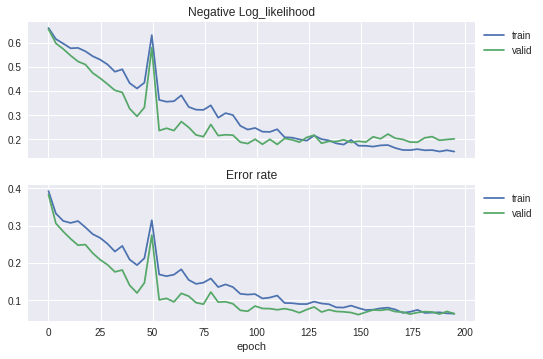

In [59]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(epoch, nll_train, label='train')
ax1.plot(epoch, nll_valid, label='valid')
ax1.legend(bbox_to_anchor=(1, 1), loc=2)
ax1.set_title('Negative Log_likelihood')

ax2.plot(epoch, 1-np.asarray(acc_train), label='train')
ax2.plot(epoch, 1-np.asarray(acc_valid), label='valid')
ax2.legend(bbox_to_anchor=(1, 1), loc=2)
ax2.set_title('Error rate')
ax2.set_xlabel('epoch')

# **Generating the submission file**

In [0]:
#model = torch.load(p_best)
#model.eval()
model.load_state_dict(torch.load(
    './eval_test_acc_0.938.pthe'))

In [0]:
class IdImageFolder(torchvision.datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        
    def __getitem__(self, index):
        """
         Args:
             index (int): Index

         Returns:
             tuple: (image, target) where target is class_index of the target class.
         """
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        p, n = osp.split(path)
        n = n.split('.')[0]
        return img, target, n
      
      

In [0]:
batch_size = 64

dogNcat_transforms = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(distrib_means, distrib_stds)])

dogNcat_test = IdImageFolder(root='./testset', 
                                    transform=dogNcat_transforms)

test_loader = torch.utils.data.DataLoader(
        dogNcat_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [0]:
import csv

with open('submission.csv', mode='w') as csv_file:
    fieldnames = ['id', 'label']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for batch in test_loader:
        x,y,id = batch
        x = x.cuda()
        raw_labels = model(x).max(1)[1].cpu().numpy()
        for i, l in zip(id, raw_labels):
            writer.writerow({'id':i, 'label':classes_dict[l]})

# **Error analysis**

In [0]:
dogNcat_error = IdImageFolder(root='./trainset', 
                              transform=dogNcat_transforms)
error_loader = torch.utils.data.DataLoader(dogNcat_error, batch_size=64, 
                                           shuffle=True, num_workers=2)
def softmax(x):
    exp = np.exp(x)
    return exp / exp.sum()

def show_random_misclassified_image(dataset_loader, n_b=3):
    ii=0
    for batch in dataset_loader:
        ii+=1
        x, y, n = batch
        if model_type == 'CNN':
            x = x.view(-1, *data_size)
            y = y.view(-1)
        if cuda:
            x = x.cuda()
            y = y.cuda()
        
        predictions = model(x)
        for i, a in enumerate(torch.eq(predictions.max(1)[1], y)):
            if not a:
                image_name = n[i]
                class_index = int(y[i].data.cpu().numpy())
                class_name = classes_dict[class_index]
                print('Image name:', image_name)
                print('Label:', class_name)
                prediction_percentages = softmax(predictions[i].detach().cpu().numpy())
                prediction_percentages = np.round(prediction_percentages * 1000) / 10
                print(f'Prediction: [Cat:', prediction_percentages[0], 
                      '%, Dog:', prediction_percentages[1], '%]')
                im = rescale_im(x[i].cpu())
                plt.imshow(im)
                return
    

Image name: 1728
Label: Dog
Prediction: [Cat: 99.7 %, Dog: 0.3 %]


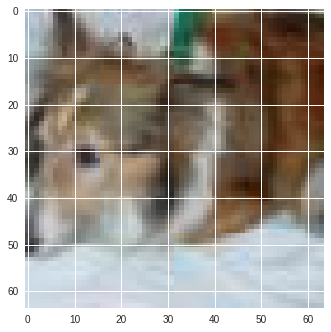

In [52]:
show_random_misclassified_image(error_loader)

# **Kernel Visualization**

Min value in all kernels: -0.38350317
Max value in all kernels: 0.3347913
New min value in all kernels: 0.0
New max value in all kernels: 1.0


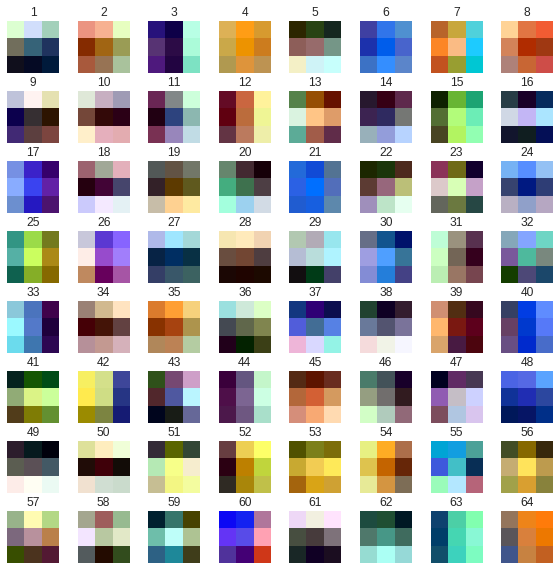

In [53]:
def visualize_kernels():
    for i, child in enumerate(model.children()):
        data = child.weight.cpu().data.numpy()
        print('Min value in all kernels:', data.min())
        print('Max value in all kernels:', data.max())
        for k in range(data.shape[0]):
            min_value = data[k].min()
            max_value = data[k].max()
            data[k] = data[k] - min_value
            data[k] = data[k] * (1 / data[k].max())
            max_value = data[k].max()
            min_value = data[k].min()
        print('New min value in all kernels:', data.min())
        print('New max value in all kernels:', data.max())
        plot_kernels(data)
        return

def plot_kernels(tensor, num_cols=8):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols*1.25,num_rows*1.25))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.set_title(i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.35)
    plt.show()

visualize_kernels()